# Dependencies

In [1]:
using CSV, DataFrames, Random

In [2]:
using Flux

In [3]:
using CUDA

In [4]:
using Plots

In [5]:
gr()
theme(:wong);

# Data loading

In [6]:
function splitdf(df, pct)
   @assert 0 <= pct <= 1
   ids = collect(axes(df, 1))
   shuffle!(ids)
   sel = ids .<= nrow(df) .* pct
   return view(df, sel, :), view(df, .!sel, :)
end;

In [7]:
df = "fashion-mnist_train.csv" |> CSV.File |> DataFrame;
df_train, df_valid = splitdf(df, 0.666)
df_test = "fashion-mnist_test.csv" |> CSV.File |> DataFrame;

In [8]:
labels = Dict(
    0 => "T-shirt",
    1 => "Trouser",
    2 => "Pullover",
    3 => "Dress",
    4 => "Coat",
    5 => "Sandal",
    6 => "Shirt",
    7 => "Sneaker",
    8 => "Bag",
    9 => "Ankle boot"
);

In [9]:
function load_y(df)
    y = df[:, :label]
    Flux.onehotbatch(y, 0:9)
end

y_train = load_y(df_train) |> y -> Flux.label_smoothing(y, 0.2f0) |> gpu
y_valid = load_y(df_valid) |> gpu;
y_test= load_y(df_test) |> gpu;

In [10]:
function load_x(df)
    x = select(df, Not(:label)) |> Matrix |> permutedims
    x = reshape(x, 28, 28, 1, :) / 255
    convert(Array{Float32,4}, x) |> m -> permutedims(m, (2,1,3,4))
end

x_train = load_x(df_train) |> gpu
x_valid = load_x(df_valid) |> gpu;
x_test = load_x(df_test) |> gpu;

# Custom training function

In [11]:
function train!(loss, ps, data, opt)
	local training_loss
	for d in data
    	gs = gradient(ps) do
      		training_loss = loss(d...)
      		return training_loss
		end
    # Insert whatever code you want here that needs training_loss, e.g. logging.
    # E.g. logging with TensorBoardLogger.jl as histogram so you can see if it is becoming huge.
    Flux.update!(opt, ps, gs)
    # Here you might like to check validation set accuracy, and break out to do early stopping.
	end
    training_loss
end;

In [12]:
predict(x) = labels[Flux.onecold(model(cat(x; dims=4)), 0:9)[1]]
get_label(y) = labels[Flux.onecold(y, 0:9)[1]]

function get_acc(model)
    function acc(x, y) 
        ŷ = model(x) |> Flux.onecold
        cy = y |> Flux.onecold
        sum(ŷ .== cy) / length(cy)
    end
end;

# CNN

In [13]:
model = Chain(
    Conv((3, 3), 1 => 32, relu)
    , AdaptiveMaxPool((14, 14))
    , Conv((3, 3), 32 => 32, relu)
    , Flux.Dropout(0.2)
    , Flux.flatten
    , Dense(4608, 32, relu)
    , Dense(32, 10)
    , softmax
) |> gpu

ps = params(model)

loss(x, y) = Flux.mse(model(x), y)

opt = ADAM()

data = Flux.DataLoader((x_train, y_train), batchsize=512, shuffle=true) |> gpu;

In [14]:
training_error = []
# vde = []
# tse = []
# ats = []
cnn_acc = get_acc(model)
@time for epoch=1:75
	push!(training_error, train!(loss, ps, data, opt))
	# push!(vde, loss(x_valid, y_valid))
	# push!(tse, loss(x_test, y_test))
	# push!(ats, cnn_acc(x_test, y_test))
end

287.748686 seconds (222.56 M allocations: 12.519 GiB, 1.71% gc time, 26.95% compilation time)


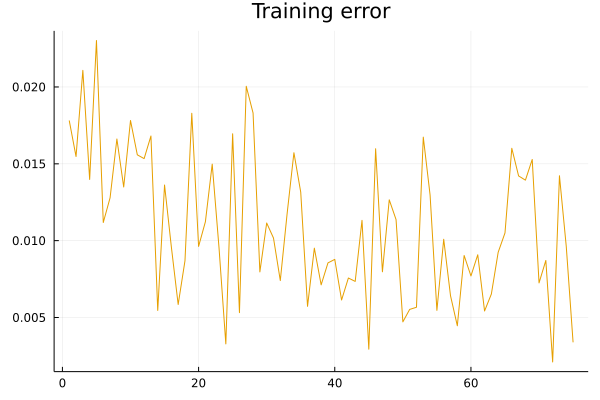

In [15]:
plot(
    plot(training_error, title="Training error")
    # , plot(vde, title="Validation error")
    # , plot(tse, title="Test error")
    # , plot(ats, title="Test accuracy")
    , legend = false
)

## Evaluation

In [16]:
cnn_acc(x_test, y_test)

0.8947

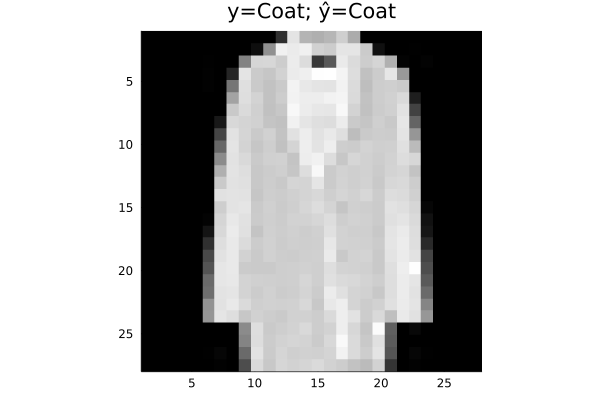

In [34]:
idx = 21
xi = x_test[:, :, 1, idx]
ŷi = xi |> predict
yi = y_test[:, idx] |> get_label
plot(Gray.(xi), title="y=$(yi); ŷ=$ŷi")

# Autoencoder

In [35]:
function x_autoenc(df)
    select(df, Not(:label)) |> Matrix |> permutedims |> m -> convert(Matrix{Float32}, m / 255) |> gpu;
end;

x_train_autoenc = df_train |>  x_autoenc
x_test_autoenc = df_test |> x_autoenc;

## Compression and decompression

In [36]:
enc = Chain(
    Dense(784, 1024, relu)
    , Dense(1024, 256, relu)
    , Dense(256, 16, relu)
) |> gpu

knw = Chain(
    Dense(16, 16, σ)
) |> gpu

dec = Chain(
    Dense(16, 256, relu)
    , Dense(256, 1024, relu)
    , Dense(1024, 784, relu)
) |> gpu

auto = Chain(
    enc
    , knw
    , dec
) |> gpu;

In [37]:
data_autoenc = Flux.DataLoader((x_train_autoenc, x_train_autoenc), batchsize=1024, shuffle=true) |> gpu;

In [38]:
loss_autoenc(x, y) = Flux.mse(auto(x), y);

First I train the encoding, knowledge and decoding networks

In [39]:
h = []
@time for e=1:200
    push!(h, train!(loss_autoenc, params(auto), data_autoenc, ADAM()))
end;

 83.250845 seconds (40.67 M allocations: 2.749 GiB, 2.35% gc time, 0.09% compilation time)


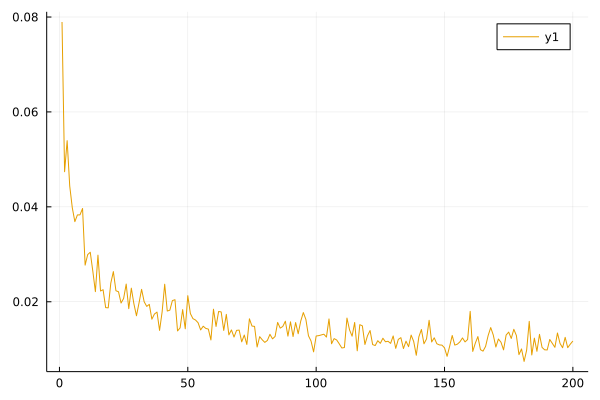

In [40]:
h |> plot

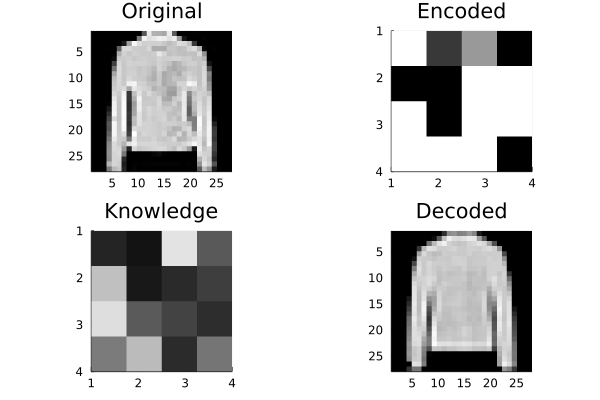

In [41]:
og = x_test_autoenc[:, 97]
en = enc(og)
kn = knw(en)
dc = dec(kn)
plot(
    plot(
        Gray.(reshape(og, 28, 28)'), title="Original"
    ),
    plot(
        Gray.(reshape(en, 4, 4)'), title="Encoded"
    ),
    plot(
        Gray.(reshape(kn, 4, 4)'), title="Knowledge"
    ),
    plot(
        Gray.(reshape(dc, 28, 28)'), title="Decoded"
    )
)

## Classification

In [42]:
clf = Chain(
    Dense(16, 32, relu)
    , Dense(32, 10)
    , softmax
) |> gpu

m2 = Chain(
    enc
    , knw
    , clf
) |> gpu;

In [43]:
data_autoenc_classif = Flux.DataLoader((knw(enc(x_train_autoenc)), y_train), batchsize=1024, shuffle=true) |> gpu;

In [44]:
loss_autoenc_classif(x, y) = Flux.mse(clf(x), y);

Then I train the classification network with the training data compressed by the encoding and knowledge networks

In [45]:
hc = []
@time for e=1:200
    push!(hc, train!(loss_autoenc_classif, params(clf), data_autoenc_classif, ADAM()))
end;

  5.598522 seconds (13.26 M allocations: 897.456 MiB, 2.91% gc time, 1.39% compilation time)


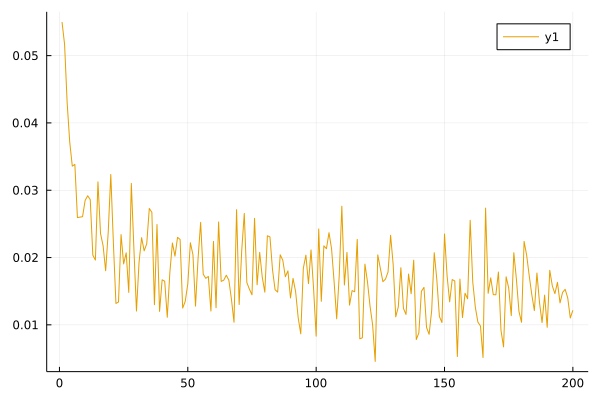

In [46]:
hc |> plot

## Evaluation

At this point I could use the m2 or the clf models.

The m2 model takes a 28x28 image as an input, compresses it with the encoding and knowledge networks, and then classifies it.

The clf model takes a compressed 4x4 image and classifies it.

In [47]:
compressed_x = x_test_autoenc |> enc |> knw

16×10000 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.940425  0.369556   0.304466  0.342902   …  0.534504   0.647912   0.729091
 0.169327  0.476021   0.187799  0.0720671     0.363696   0.0770572  0.0871172
 0.341197  0.0354029  0.538205  0.338364      0.814999   0.48862    0.540134
 0.803808  0.400577   0.49707   0.232363      0.0970822  0.6102     0.216925
 0.25419   0.622433   0.39763   0.370179      0.311225   0.31504    0.537176
 0.13793   0.963279   0.253031  0.642356   …  0.79141    0.0390155  0.0916268
 0.28535   0.0985808  0.380226  0.190825      0.310181   0.168932   0.0828913
 0.528243  0.768223   0.463189  0.176289      0.0415898  0.0342672  0.588168
 0.579654  0.0354131  0.733973  0.828916      0.137161   0.84145    0.753332
 0.083266  0.30258    0.494886  0.09353       0.0138732  0.157423   0.0921301
 0.127386  0.104193   0.45664   0.145326   …  0.0288254  0.151292   0.0605917
 0.156033  0.225684   0.316097  0.392282      0.526755   0.287957   0.0411403
 0.953783  0.3492

In [48]:
autoenc_preds = compressed_x |> clf |> Flux.onecold;

In [49]:
accuracy_autoenc = get_acc(clf)
accuracy_autoenc(compressed_x, y_test)

0.8382